In [2]:
import os
import pandas as pd

# Define the path to the 'combined_images' directory
base_path = 'combined_images'

# Define the mapping of classes to numerical labels
label_mapping = {
    'NonDemented': 0,
    'VeryMildDemented': 1,
    'MildDemented': 2,
    'ModerateDemented': 3
}

# Prepare lists to hold file paths and labels
file_paths = []
labels = []

# Iterate through each class directory and collect file paths and labels
for class_name, label in label_mapping.items():
    class_path = os.path.join(base_path, class_name)
    for file in os.listdir(class_path):
        # Only consider image files (assuming JPG, but adjust as necessary)
        if file.endswith('.jpg'):
            file_paths.append(os.path.join(class_path, file))
            labels.append(label)

# Create a DataFrame
df = pd.DataFrame({
    'file_path': file_paths,
    'label': labels
})

# Display the first few rows of the DataFrame
print(df.head())


                                           file_path  label
0  combined_images/NonDemented/cdc1752f-b9a5-4641...      0
1  combined_images/NonDemented/6083a08c-dc81-4e8d...      0
2         combined_images/NonDemented/nonDem1498.jpg      0
3         combined_images/NonDemented/nonDem2191.jpg      0
4  combined_images/NonDemented/6cee9615-8ab4-4069...      0


In [3]:
df.shape

(40384, 2)

In [4]:
label_counts = df['label'].value_counts()
print(label_counts)

label
0    12800
1    11200
2     9856
3     6528
Name: count, dtype: int64


In [5]:
from sklearn.model_selection import train_test_split

# Split data into training plus validation and testing
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Split training plus validation data into separate training and validation sets
train_df, val_df = train_test_split(train_val_df, test_size=0.2, stratify=train_val_df['label'], random_state=42)  

# Optionally sample the training and validation set for hyperparameter tuning
#train_df = train_df.sample(frac=0.1, random_state=42)  # Adjust frac as needed for tuning
#val_df = val_df.sample(frac=0.5, random_state=42)  # Optionally adjust frac as needed for tuning

# Example: Cleaning NaN values from your dataframe (if applicable, especially for labels or any numerical features)
train_df = train_df.dropna()
val_df = val_df.dropna()
test_df = test_df.dropna()

# Note: The test set should not be sampled or altered from its initial split
# test_df remains as is for final model evaluation to ensure accuracy of performance metrics

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Testing set size: {len(test_df)}") 

Training set size: 25845
Validation set size: 6462
Testing set size: 8077


In [6]:
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch

class MRIDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['file_path']
        image = Image.open(img_path).convert('L')  # Convert image to greyscale
        label = self.dataframe.iloc[idx]['label']
        if self.transform:
            image = self.transform(image)
        #print(image.shape)
        label = torch.tensor(label, dtype=torch.long)  # Convert label to a LongTensor
        return image, label

# Define transformations/augmentations
transformations = transforms.Compose([
    transforms.Resize(128),  # Resize the image
    transforms.CenterCrop(128),  # Crop the center 224x224 pixels
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_test_transformations = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create training and testing datasets
train_dataset = MRIDataset(train_df, transform=transformations)
val_dataset = MRIDataset(val_df, transform=val_test_transformations)
test_dataset = MRIDataset(test_df, transform=val_test_transformations)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

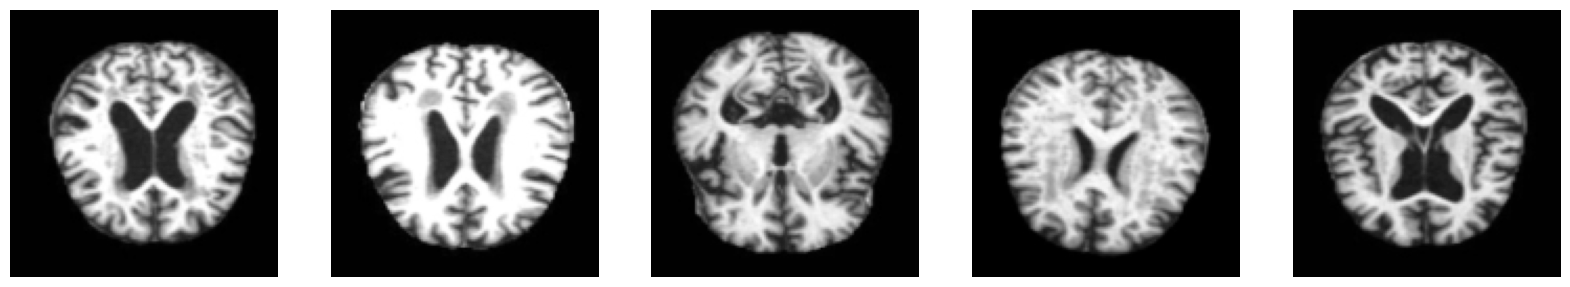

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display a batch of images
def show_images(images, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            # Convert the tensor image to a NumPy array and do normalization
            # The .numpy() method moves the tensor to cpu and converts it to a NumPy array
            img = images[i].numpy()
            # Since the images were transformed to tensors, the channel is the first dimension
            # but matplotlib expects the channel to be the third dimension
            img = np.transpose(img, (1, 2, 0))
            # Display image
            ax.imshow(img, cmap='gray')
            ax.axis('off')
    plt.show()

# Get a single batch of images
images, labels = next(iter(train_loader))

# Show images
show_images(images)

In [8]:
import jax
import jaxlib

from quantum_transformers.utils import plot_image
from quantum_transformers.datasets import get_mnist_dataloaders
from quantum_transformers.training import train_and_evaluate
from quantum_transformers.transformers import VisionTransformer
from quantum_transformers.quantum_layer import get_circuit

model = VisionTransformer(
    num_classes=4,
    patch_size=48,  # Consider increasing patch size to reduce sequence length
    hidden_size=8,  # Reduce model complexity
    num_heads=4,  # Reduce number of heads
    num_transformer_blocks=8,  # Reduce the depth
    mlp_hidden_size=6,  # Reduce MLP block size
    quantum_attn_circuit=get_circuit(),
    quantum_mlp_circuit=get_circuit(),
    pos_embedding='learn'  # Positional embedding
)

Please first ``pip install -U qiskit`` to enable related functionality in translation module


In [9]:
num_classes = 4
num_epochs = 50

# Call the train_and_evaluate function with the adjusted parameters
test_loss, test_auc, test_fpr, test_tpr, all_logits, all_labels = train_and_evaluate(
    model=model, 
    train_dataloader=train_loader, 
    val_dataloader=val_loader, 
    test_dataloader=test_loader, 
    num_classes=num_classes,
    num_epochs=num_epochs,
)

Number of parameters = 19964
Starting training for 50 epochs...


Epoch   1/50:   0%|          | 0/808 [00:00<?, ?batch/s]2024-02-22 00:47:19.891245: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_train_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-02-22 01:02:48.401968: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 17m28.513928s

********************************
[Compiling module jit_train_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch   1/50: 100%|█████████▉| 807/808 [24:34<00:00,  2.23batch/s]    2024-02-22 01:25:28.869916: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 15m35.054527s

********************************
[Compiling module jit_train_step] Very slow compile? If you want to file a bug, run

Epoch 1 completed. Validation Loss: 1.2659, Validation AUC: 66.06%


Epoch   2/50: 100%|██████████| 808/808 [05:10<00:00,  2.60batch/s, Loss = 1.1774, AUC = 72.68%]


Epoch 2 completed. Validation Loss: 1.1774, Validation AUC: 72.68%


Epoch   3/50: 100%|██████████| 808/808 [04:54<00:00,  2.74batch/s, Loss = 1.1277, AUC = 74.74%]


Epoch 3 completed. Validation Loss: 1.1277, Validation AUC: 74.74%


Epoch   4/50: 100%|██████████| 808/808 [04:52<00:00,  2.77batch/s, Loss = 1.0708, AUC = 77.04%]


Epoch 4 completed. Validation Loss: 1.0708, Validation AUC: 77.04%


Epoch   5/50: 100%|██████████| 808/808 [04:48<00:00,  2.80batch/s, Loss = 1.0774, AUC = 77.35%]


Epoch 5 completed. Validation Loss: 1.0774, Validation AUC: 77.35%


Epoch   6/50: 100%|██████████| 808/808 [04:49<00:00,  2.79batch/s, Loss = 1.0504, AUC = 78.40%]


Epoch 6 completed. Validation Loss: 1.0504, Validation AUC: 78.40%


Epoch   7/50: 100%|██████████| 808/808 [04:51<00:00,  2.77batch/s, Loss = 1.1763, AUC = 77.27%]


Epoch 7 completed. Validation Loss: 1.1763, Validation AUC: 77.27%


Epoch   8/50: 100%|██████████| 808/808 [04:52<00:00,  2.76batch/s, Loss = 0.9850, AUC = 80.20%]


Epoch 8 completed. Validation Loss: 0.9850, Validation AUC: 80.20%


Epoch   9/50: 100%|██████████| 808/808 [05:01<00:00,  2.68batch/s, Loss = 0.9838, AUC = 80.07%]


Epoch 9 completed. Validation Loss: 0.9838, Validation AUC: 80.07%


Epoch  10/50: 100%|██████████| 808/808 [05:01<00:00,  2.68batch/s, Loss = 0.9832, AUC = 80.62%]


Epoch 10 completed. Validation Loss: 0.9832, Validation AUC: 80.62%


Epoch  11/50: 100%|██████████| 808/808 [04:56<00:00,  2.73batch/s, Loss = 0.9736, AUC = 80.79%]


Epoch 11 completed. Validation Loss: 0.9736, Validation AUC: 80.79%


Epoch  12/50: 100%|██████████| 808/808 [04:58<00:00,  2.71batch/s, Loss = 0.9608, AUC = 81.14%]


Epoch 12 completed. Validation Loss: 0.9608, Validation AUC: 81.14%


Epoch  13/50: 100%|██████████| 808/808 [05:03<00:00,  2.66batch/s, Loss = 0.9581, AUC = 81.15%]


Epoch 13 completed. Validation Loss: 0.9581, Validation AUC: 81.15%


Epoch  14/50: 100%|██████████| 808/808 [05:03<00:00,  2.66batch/s, Loss = 0.9419, AUC = 81.66%]


Epoch 14 completed. Validation Loss: 0.9419, Validation AUC: 81.66%


Epoch  15/50: 100%|██████████| 808/808 [05:04<00:00,  2.65batch/s, Loss = 0.9628, AUC = 81.11%]


Epoch 15 completed. Validation Loss: 0.9628, Validation AUC: 81.11%


Epoch  16/50: 100%|██████████| 808/808 [05:04<00:00,  2.66batch/s, Loss = 0.9574, AUC = 81.75%]


Epoch 16 completed. Validation Loss: 0.9574, Validation AUC: 81.75%


Epoch  17/50: 100%|██████████| 808/808 [05:07<00:00,  2.63batch/s, Loss = 0.9466, AUC = 81.68%]


Epoch 17 completed. Validation Loss: 0.9466, Validation AUC: 81.68%


Epoch  18/50: 100%|██████████| 808/808 [05:09<00:00,  2.61batch/s, Loss = 0.9459, AUC = 81.80%]


Epoch 18 completed. Validation Loss: 0.9459, Validation AUC: 81.80%


Epoch  19/50: 100%|██████████| 808/808 [05:06<00:00,  2.64batch/s, Loss = 0.9262, AUC = 82.50%]


Epoch 19 completed. Validation Loss: 0.9262, Validation AUC: 82.50%


Epoch  20/50: 100%|██████████| 808/808 [05:04<00:00,  2.65batch/s, Loss = 0.9270, AUC = 82.35%]


Epoch 20 completed. Validation Loss: 0.9270, Validation AUC: 82.35%


Epoch  21/50: 100%|██████████| 808/808 [05:05<00:00,  2.65batch/s, Loss = 0.9188, AUC = 82.61%]


Epoch 21 completed. Validation Loss: 0.9188, Validation AUC: 82.61%


Epoch  22/50: 100%|██████████| 808/808 [05:05<00:00,  2.64batch/s, Loss = 0.9218, AUC = 82.66%]


Epoch 22 completed. Validation Loss: 0.9218, Validation AUC: 82.66%


Epoch  23/50: 100%|██████████| 808/808 [05:06<00:00,  2.63batch/s, Loss = 0.9169, AUC = 82.68%]


Epoch 23 completed. Validation Loss: 0.9169, Validation AUC: 82.68%


Epoch  24/50: 100%|██████████| 808/808 [05:05<00:00,  2.64batch/s, Loss = 0.9177, AUC = 82.92%]


Epoch 24 completed. Validation Loss: 0.9177, Validation AUC: 82.92%


Epoch  25/50: 100%|██████████| 808/808 [05:04<00:00,  2.66batch/s, Loss = 0.9229, AUC = 82.79%]


Epoch 25 completed. Validation Loss: 0.9229, Validation AUC: 82.79%


Epoch  26/50: 100%|██████████| 808/808 [05:04<00:00,  2.65batch/s, Loss = 0.9112, AUC = 82.85%]


Epoch 26 completed. Validation Loss: 0.9112, Validation AUC: 82.85%


Epoch  27/50: 100%|██████████| 808/808 [05:06<00:00,  2.64batch/s, Loss = 0.9121, AUC = 83.25%]


Epoch 27 completed. Validation Loss: 0.9121, Validation AUC: 83.25%


Epoch  28/50: 100%|██████████| 808/808 [05:08<00:00,  2.62batch/s, Loss = 0.9149, AUC = 83.13%]


Epoch 28 completed. Validation Loss: 0.9149, Validation AUC: 83.13%


Epoch  29/50: 100%|██████████| 808/808 [05:07<00:00,  2.63batch/s, Loss = 0.9044, AUC = 83.27%]


Epoch 29 completed. Validation Loss: 0.9044, Validation AUC: 83.27%


Epoch  30/50: 100%|██████████| 808/808 [05:06<00:00,  2.64batch/s, Loss = 0.8945, AUC = 83.57%]


Epoch 30 completed. Validation Loss: 0.8945, Validation AUC: 83.57%


Epoch  31/50: 100%|██████████| 808/808 [05:04<00:00,  2.65batch/s, Loss = 0.9007, AUC = 83.37%]


Epoch 31 completed. Validation Loss: 0.9007, Validation AUC: 83.37%


Epoch  32/50: 100%|██████████| 808/808 [05:05<00:00,  2.65batch/s, Loss = 0.9024, AUC = 83.61%]


Epoch 32 completed. Validation Loss: 0.9024, Validation AUC: 83.61%


Epoch  33/50: 100%|██████████| 808/808 [05:05<00:00,  2.64batch/s, Loss = 0.8940, AUC = 83.74%]


Epoch 33 completed. Validation Loss: 0.8940, Validation AUC: 83.74%


Epoch  34/50: 100%|██████████| 808/808 [05:06<00:00,  2.63batch/s, Loss = 0.9150, AUC = 83.48%]


Epoch 34 completed. Validation Loss: 0.9150, Validation AUC: 83.48%


Epoch  35/50: 100%|██████████| 808/808 [05:05<00:00,  2.65batch/s, Loss = 0.8882, AUC = 83.98%]


Epoch 35 completed. Validation Loss: 0.8882, Validation AUC: 83.98%


Epoch  36/50: 100%|██████████| 808/808 [05:04<00:00,  2.65batch/s, Loss = 0.8945, AUC = 83.89%]


Epoch 36 completed. Validation Loss: 0.8945, Validation AUC: 83.89%


Epoch  37/50: 100%|██████████| 808/808 [05:02<00:00,  2.67batch/s, Loss = 0.8909, AUC = 83.95%]


Epoch 37 completed. Validation Loss: 0.8909, Validation AUC: 83.95%


Epoch  38/50: 100%|██████████| 808/808 [05:07<00:00,  2.63batch/s, Loss = 0.8860, AUC = 84.05%]


Epoch 38 completed. Validation Loss: 0.8860, Validation AUC: 84.05%


Epoch  39/50: 100%|██████████| 808/808 [05:07<00:00,  2.63batch/s, Loss = 0.8889, AUC = 84.10%]


Epoch 39 completed. Validation Loss: 0.8889, Validation AUC: 84.10%


Epoch  40/50: 100%|██████████| 808/808 [05:03<00:00,  2.66batch/s, Loss = 0.8839, AUC = 84.13%]


Epoch 40 completed. Validation Loss: 0.8839, Validation AUC: 84.13%


Epoch  41/50: 100%|██████████| 808/808 [05:03<00:00,  2.66batch/s, Loss = 0.8817, AUC = 84.21%]


Epoch 41 completed. Validation Loss: 0.8817, Validation AUC: 84.21%


Epoch  42/50: 100%|██████████| 808/808 [05:05<00:00,  2.64batch/s, Loss = 0.8872, AUC = 84.04%]


Epoch 42 completed. Validation Loss: 0.8872, Validation AUC: 84.04%


Epoch  43/50: 100%|██████████| 808/808 [05:04<00:00,  2.65batch/s, Loss = 0.8926, AUC = 83.87%]


Epoch 43 completed. Validation Loss: 0.8926, Validation AUC: 83.87%


Epoch  44/50: 100%|██████████| 808/808 [05:07<00:00,  2.63batch/s, Loss = 0.8778, AUC = 84.29%]


Epoch 44 completed. Validation Loss: 0.8778, Validation AUC: 84.29%


Epoch  45/50: 100%|██████████| 808/808 [05:05<00:00,  2.65batch/s, Loss = 0.8760, AUC = 84.44%]


Epoch 45 completed. Validation Loss: 0.8760, Validation AUC: 84.44%


Epoch  46/50: 100%|██████████| 808/808 [05:05<00:00,  2.64batch/s, Loss = 0.8761, AUC = 84.46%]


Epoch 46 completed. Validation Loss: 0.8761, Validation AUC: 84.46%


Epoch  47/50: 100%|██████████| 808/808 [05:04<00:00,  2.65batch/s, Loss = 0.8758, AUC = 84.45%]


Epoch 47 completed. Validation Loss: 0.8758, Validation AUC: 84.45%


Epoch  48/50: 100%|██████████| 808/808 [05:06<00:00,  2.64batch/s, Loss = 0.8740, AUC = 84.54%]


Epoch 48 completed. Validation Loss: 0.8740, Validation AUC: 84.54%


Epoch  49/50: 100%|██████████| 808/808 [05:06<00:00,  2.63batch/s, Loss = 0.8738, AUC = 84.64%]


Epoch 49 completed. Validation Loss: 0.8738, Validation AUC: 84.64%


Epoch  50/50: 100%|██████████| 808/808 [05:04<00:00,  2.66batch/s, Loss = 0.8753, AUC = 84.55%]


Epoch 50 completed. Validation Loss: 0.8753, Validation AUC: 84.55%
Total training time = 17795.23s, best validation AUC = 84.64% at epoch 49
Total training time: 17812.53 seconds
Training Losses: []
Training AUCs: []
Validation Losses: [Array(1.2658771, dtype=float32), Array(1.1774313, dtype=float32), Array(1.127664, dtype=float32), Array(1.0708236, dtype=float32), Array(1.077367, dtype=float32), Array(1.0503924, dtype=float32), Array(1.1763313, dtype=float32), Array(0.9849932, dtype=float32), Array(0.98382205, dtype=float32), Array(0.983239, dtype=float32), Array(0.97357523, dtype=float32), Array(0.9607847, dtype=float32), Array(0.958135, dtype=float32), Array(0.94192827, dtype=float32), Array(0.9628407, dtype=float32), Array(0.95744807, dtype=float32), Array(0.94658464, dtype=float32), Array(0.9459301, dtype=float32), Array(0.9262416, dtype=float32), Array(0.9270042, dtype=float32), Array(0.9187744, dtype=float32), Array(0.92177296, dtype=float32), Array(0.9168596, dtype=float32), A

Testing: 100%|█████████▉| 252/253 [00:35<00:00,  7.09batch/s]2024-02-22 05:44:40.312496: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m59.605306s

********************************
[Compiling module jit_eval_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Testing: 100%|██████████| 253/253 [03:48<00:00,  1.11batch/s, Loss = 0.8895, AUC = 84.02%]
2024-02-22 05:44:41,549	WARNING session.py:100 -- In neither tune session nor train session!


In [10]:
import pickle
with open('stripped2.pkl', 'wb') as f:
    pickle.dump((test_fpr, test_tpr, test_auc / 100), f)